<a href="https://colab.research.google.com/github/elliemmiller/datascience/blob/main/Module2FirstPass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Module 2 First Pass Assignment**

Produced by: Ellie Miller


The purpose of this assignment is to try out three different unsupervised learning methods on the dataset used for the previous assignment. I am using the World Glacier Inventory Dataset from NSIDC, which is publically available on Kaggle.

**Set Up**

In [ ]:
!pip install umap-learn

# Import necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Access the API to load the dataset and save it as a ZIP
!kaggle datasets download -d nsidcorg/glacier-inventory

with zipfile.ZipFile("glacier-inventory.zip", 'r') as zip_ref:
    zip_ref.extractall("glacier-inventory")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 1.1 MB/s eta 0:00:00
Dataset URL: https://www.kaggle.com/datasets/nsidcorg/glacier-inventory
License(s): CC0-1.0
glacier-inventory.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Load the database file
worldglacierinventory = pd.read_csv('/content/glacier-inventory/database.csv')

<ipython-input-35-14ea40a94235>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  worldglacierinventory = pd.read_csv('/content/glacier-inventory/database.csv')


In [ ]:
# Select only the columns with useful data for ML approaches-removed elevation per Thomas's suggestion
worldglacierinventoryremove = worldglacierinventory[['Glacier Area', 'Mean Length', 'Mean Width', 'Mean Depth']]

# Remove any row with no data
worldglacierinventorycondense = worldglacierinventoryremove.dropna()
worldglacierinventorycondense.shape

(39089, 4)

**Normalize the Data**

In [ ]:
# Normalize the data for all the unsupervised ML methods
scaler = StandardScaler()
data_normalized = scaler.fit_transform(worldglacierinventorycondense)

**Unsupervised Method #1: K-Means**

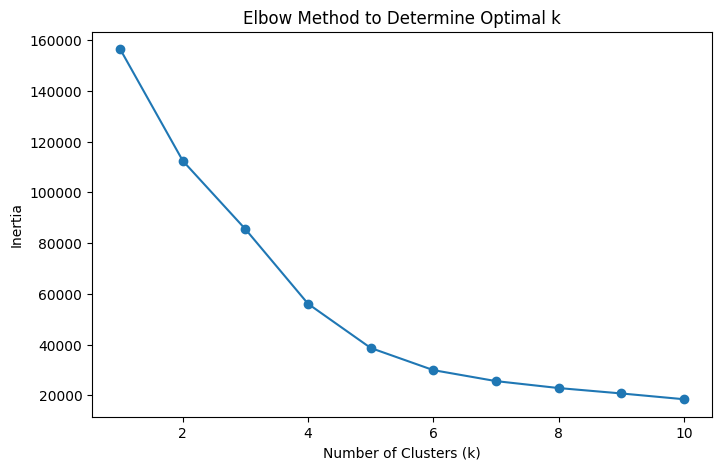

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve to determine the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [ ]:
# Define optimal number of clusters
optimal_k = 3

# Fit KMeans with the optimal number of clusters and calculate the silhouette score
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_optimal.fit_predict(data_normalized)

# Calculate the silhouette score for the clustering
silhouette_avg = silhouette_score(data_normalized, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.78


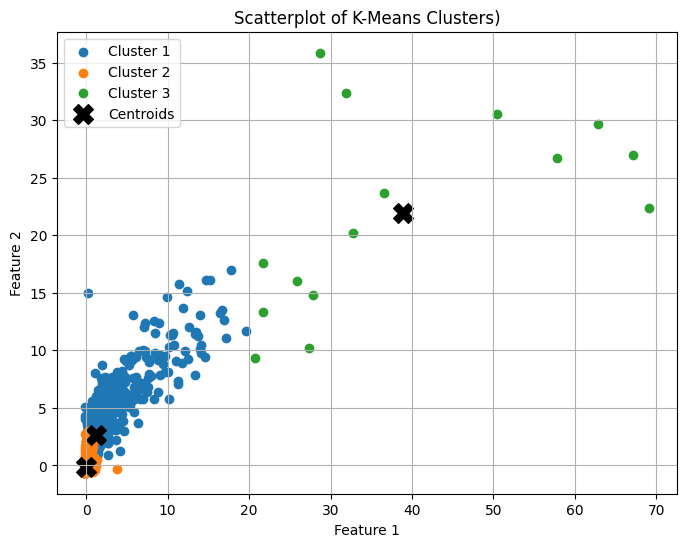

In [ ]:
# Scatterplot of the clusters
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    cluster_points = data_normalized[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i + 1}")

# Cluster centroids
centroids = kmeans_optimal.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title(f"Scatterplot of K-Means Clusters)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

**Write-Up**

After normalizing the data, I went ahead and determined the optimal number of clusters using the Elbow method. This determined that 3 is the ideal number of clusters for this dataset. I then calculated a silhouette score for the clustering, which yielded a value of 0.78, which indicates decent clustering. Lastly, to visualize the data, I used the scatterplot feature and then added centroids on top.

**Unsupervised Method #2: DBSCAN**

In [ ]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_normalized)

# Number of clusters (excluding noise)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

Number of clusters: 8
Number of noise points: 342


In [ ]:
# Calculate silhouette score for DBSCAN
dbscan_silhouette = silhouette_score(data_normalized[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])
print(f"Silhouette Score: {dbscan_silhouette:.2f}")

Silhouette Score: 0.23


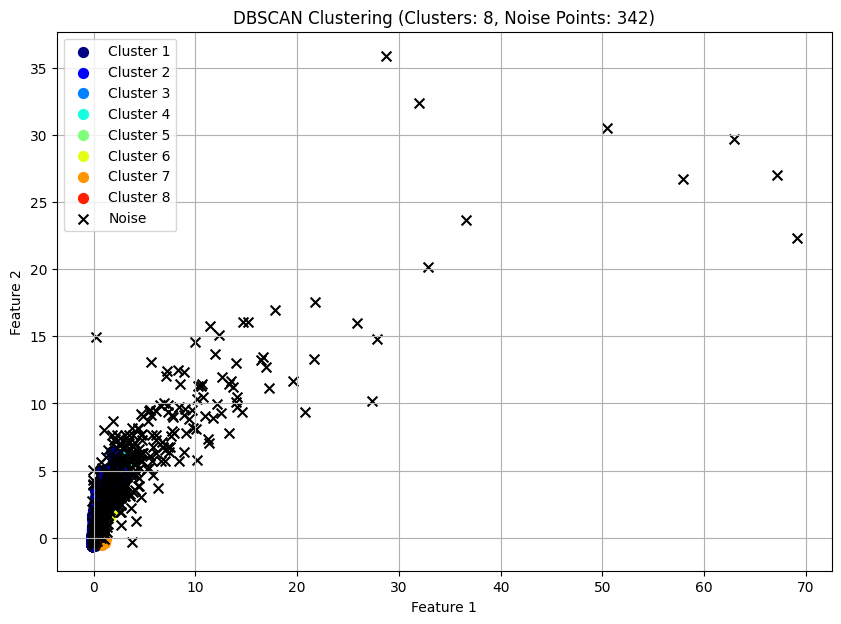

In [ ]:
# Scatterplot for DBSCAN clustering results
plt.figure(figsize=(10, 7))
unique_labels = set(dbscan_labels)

for label in unique_labels:
    if label == -1:
        # Noise points
        color = 'k'
        marker = 'x'
        label_name = 'Noise'
    else:
        # Cluster points
        color = plt.cm.jet(float(label) / n_clusters)
        marker = 'o'
        label_name = f'Cluster {label + 1}'

    cluster_points = data_normalized[dbscan_labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[color], label=label_name, marker=marker, s=50)

plt.title(f"DBSCAN Clustering)")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.grid(True)
plt.show()

**Write-Up**

After normalizing the data, I used DBSCAN to determine the optimal number of clusters as well as the amount of noise points. Noise points are outliers generated during collection or processing that can adversely influence analysis. I also calculated the silhouette score, which yielded a value of 0.23. Lastly, to visualize the data, I then used the scatterplot feature to produce the plot above. The plot includes the clusters as well as the noise points, which obscure much of the rest of the plot.

**Unsupervised Method #3: UMAP**

In [ ]:
# Perform UMAP dimensionality reduction
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
data_umap = umap_reducer.fit_transform(data_normalized)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


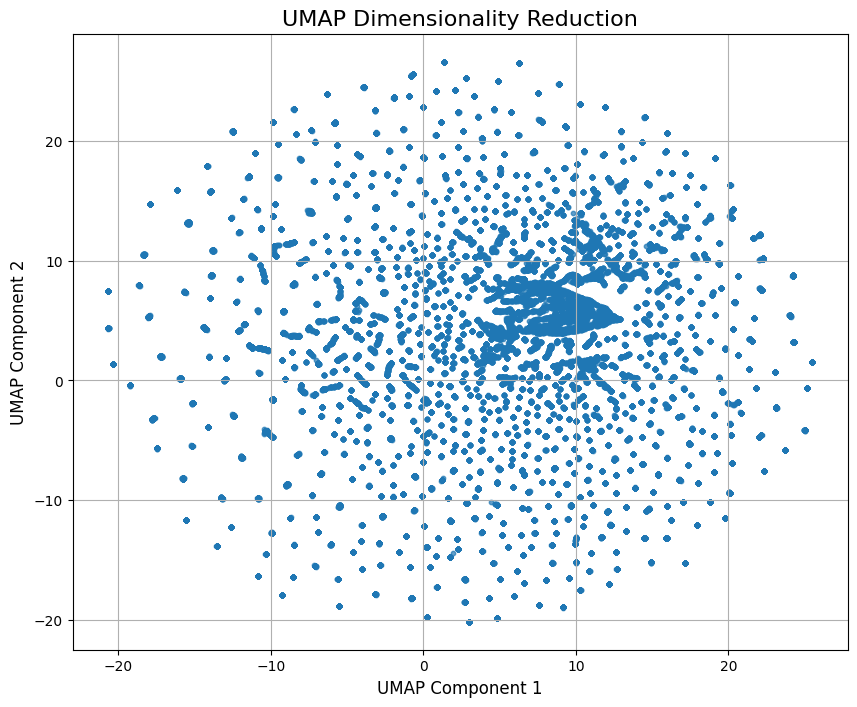

In [ ]:
# Visualize results of UMAP dimensionality reduction
plt.figure(figsize=(10, 8))
plt.scatter(data_umap[:, 0], data_umap[:, 1], s=10, alpha=0.7)

# Plot characteristics
plt.title('UMAP Dimensionality Reduction', fontsize=16)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.grid(True)
plt.show()

**Write-Up**

After normalizing the data, I performed a dimensionality reduction using UMAP. Since this is a dimensionality reduction, we cannot calculate any silhouette score since it does not determine the optimal number of clusters. I then visualized the results with a scatterplot.

**Required Reflection Questions from Canvas**

*Which method did you like the most?*

I found K-Means to be the most intuitive and, therefore, my favorite method. My analysis identified a reasonable number of optimal clusters with a relatively high silhouette score, suggesting that the clustering was meaningful and aligned well with the dataset.

*Which method did you like the least?*

The UMAP method was my least favorite. While I understand that it performs dimensionality reduction rather than clustering, I struggled to interpret the results and connect them to actionable insights or the other clustering methods like DBSCAN or K-Means.

*How did you score these unsupervised models? *

I evaluated the unsupervised models primarily using the silhouette score. This metric measures the quality of clustering, with values ranging from -1 to 1. A higher score indicates better-defined clusters. However, I could only apply the silhouette score to K-Means and DBSCAN, as UMAP is not inherently a clustering algorithm.

*Did the output align with your geologic understanding?*

The clusters identified by K-Means appeared to align reasonably well with my geologic understanding of the dataset. Further investigation would be needed to confirm whether these clusters represent meaningful geophysical patterns.

*What did you want to learn more about?*

I want to deepen my understanding of UMAP and its applications. Specifically, I would like to explore how its results can be effectively interpreted and integrated with clustering techniques like K-Means or DBSCAN to uncover meaningful insights.

*Did you pre-process your data?*

Yes, I pre-processed the data to prepare it for machine learning. This involved selecting columns that contained useful data for ML purposes, removing any missing values, and normalizing the dataset using StandardScaler and its fit_transform method.

*What was a decision you were most unsure about?*

The decision I felt most uncertain about was determining the number of clusters to use. This is a common challenge in unsupervised machine learning, as there is often no definitive answer. The Elbow Method provided guidance, but I still found this aspect of the analysis challenging.